# Thiết lập và cài đặt

In [ ]:
# Clone Source Code của paper gốc và tải các thư viện cần dùng
!git clone https://github.com/facebookresearch/DPR.git
%cd DPR
!pip install .
!pip install torch transformers faiss-gpu matplotlib ipywidgets
!pip install hydra-core

# Import các thư viện
import torch
import transformers
import faiss
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import ipywidgets as widgets
from transformers import DPRQuestionEncoder, DPRContextEncoder
from IPython.display import display, HTML
from pathlib import Path
import time
from datetime import datetime
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
from transformers import (
    DPRQuestionEncoder,
    DPRContextEncoder,
    AutoTokenizer
)
# Check GPU và setup
def setup_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"Using GPU: {torch.cuda.get_device_name(0)}")
        print(f"Memory Available: {torch.cuda.get_device_properties(0).total_memory/1e9:.2f} GB")
    else:
        device = torch.device("cpu")
        print("No GPU available, using CPU")
    return device

device = setup_device()


fatal: destination path 'DPR' already exists and is not an empty directory.
/content/DPR
Processing /content/DPR
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Using GPU: Tesla T4
Memory Available: 15.84 GB


Tải các pre-trained model

In [2]:
!pip install wget

# Download pre-trained models và data
!python dpr/data/download_data.py --resource checkpoint.retriever.single-adv-hn.nq.bert-base-encoder
!python dpr/data/download_data.py --resource data.wikipedia_split.psgs_w100
!python dpr/data/download_data.py --resource data.retriever.qas.nq-test

# Giới hạn passages cho demo (trên 21.000.000 passages)
NUM_PASSAGES = 100000

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=8e02ede83e13f49473d02b56d5d98713b7833072a17bedc93fdc71f1cbe779fa
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
^C


# Kiến trúc DPR

In [3]:
# Kiến trúc cốt lõi của DPR
"""
Kiến trúc DPR gồm 2 thành phần chính:
1. Question Encoder: BERT để encode câu hỏi thành vector
2. Passage Encoder: BERT để encode đoạn văn thành vector
Similarity Score: Tính điểm tương đồng bằng tích vô hướng
"""

class DPRQuestionEncoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = transformers.BertModel.from_pretrained('bert-base-uncased')

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        return outputs[0][:,0,:] # [CLS] token

class DPRPassageEncoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = transformers.BertModel.from_pretrained('bert-base-uncased')

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        return outputs[0][:,0,:] # [CLS] token

# Khởi tạo tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

# Load các model và passage

Load các model để sử dụng

In [ ]:


def load_dpr_models():
    """Load DPR models và tokenizer"""
    # Load encoders
    question_encoder = DPRQuestionEncoder.from_pretrained('facebook/dpr-question_encoder-single-nq-base')
    context_encoder = DPRContextEncoder.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base')

    tokenizer = AutoTokenizer.from_pretrained('facebook/dpr-question_encoder-single-nq-base')

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    question_encoder = question_encoder.to(device)
    context_encoder = context_encoder.to(device)

    return question_encoder, context_encoder, tokenizer

# Load models và tokenizer
question_encoder, context_encoder, tokenizer = load_dpr_models()
print("Models and tokenizer loaded successfully")

config.json:   0%|          | 0.00/493 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/dpr-question_encoder-single-nq-base were not used when initializing DPRQuestionEncoder: ['question_encoder.bert_model.pooler.dense.bias', 'question_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRQuestionEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRQuestionEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


config.json:   0%|          | 0.00/492 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/dpr-ctx_encoder-single-nq-base were not used when initializing DPRContextEncoder: ['ctx_encoder.bert_model.pooler.dense.bias', 'ctx_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRContextEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRContextEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Models and tokenizer loaded successfully


In [5]:
'''
# Load model đã train sẵn
def load_dpr_model():
    question_encoder = DPRQuestionEncoder()
    passage_encoder = DPRPassageEncoder()

    # Load checkpoint
    checkpoint = torch.load('checkpoint.retriever.single-adv-hn.nq.bert-base-encoder')

    question_encoder.load_state_dict(checkpoint['question_encoder'])
    passage_encoder.load_state_dict(checkpoint['passage_encoder'])

    return question_encoder, passage_encoder

question_encoder, passage_encoder = load_dpr_model()
'''

"\n# Load model đã train sẵn\ndef load_dpr_model():\n    question_encoder = DPRQuestionEncoder()\n    passage_encoder = DPRPassageEncoder()\n\n    # Load checkpoint\n    checkpoint = torch.load('checkpoint.retriever.single-adv-hn.nq.bert-base-encoder')\n\n    question_encoder.load_state_dict(checkpoint['question_encoder'])\n    passage_encoder.load_state_dict(checkpoint['passage_encoder'])\n\n    return question_encoder, passage_encoder\n\nquestion_encoder, passage_encoder = load_dpr_model()\n"

Load các passage để demo code

In [ ]:
# Generate embeddings cho passages (giới hạn số lượng để demo)
NUM_PASSAGES = 100000  # Giới hạn số passages để demo
'''
def load_passages(path, max_passages=NUM_PASSAGES):
    passages = []
    with open(path) as f:
        next(f)  # Skip header
        for i, line in enumerate(f):
            if i >= max_passages:
                break
            pid, text, title = line.strip().split('\t')
            passages.append({
                'id': pid,
                'text': text,
                'title': title
            })
    return passages
'''
# Load Wikipedia passages

def load_passages(path, max_passages=100000):
    """
    Load passages từ gzipped TMP file
    Args:
        path: Đường dẫn cho gzipped TMP file
        max_passages: Số lượng tối đa của passages load lên
    Returns:
        List các passages với id, text, and title
    """
    passages = []
    try:
        with gzip.open(path, 'rt', encoding='utf-8') as f:
            # Skip header
            next(f)

            # Load passages
            for i, line in enumerate(f):
                if i >= max_passages:
                    break

                pid, text, title = line.strip().split('\t')
                passages.append({
                    'id': pid,
                    'text': text,
                    'title': title
                })

        print(f"Loaded {len(passages)} passages")
        return passages

    except Exception as e:
        print(f"Error loading passages: {e}")
        return []

passages = load_passages('/content/DPR/downloads/data/wikipedia_split/psgs_w100.tmp')
# passages = load_passages('/content/DPR/downloads/data/wikipedia_split/psgs_w100.tmp')

Loaded 100000 passages


# Các hàm liên quan

Tạo các embedding

In [7]:

def generate_embeddings(encoder, passages, batch_size=32):
    embeddings = []

    for i in tqdm(range(0, len(passages), batch_size)):
        batch = passages[i:i+batch_size]
        texts = [p['text'] for p in batch]

        # Tokenize và chuyển sang GPU
        inputs = tokenizer(texts,
                         return_tensors='pt',
                         padding=True,
                         truncation=True,
                         max_length=256)
        inputs = {k:v.to(device) for k,v in inputs.items()}

        # Generate embeddings trên GPU
        with torch.no_grad():
            emb = encoder(**inputs).pooler_output
            embeddings.append(emb.cpu())

    return torch.cat(embeddings, dim=0)

# Generate embeddings với GPU
passage_embeddings = generate_embeddings(context_encoder, passages)
# Lưu embeddings
torch.save(passage_embeddings, 'passage_embeddings.pt')

  0%|          | 0/3125 [00:00<?, ?it/s]

Tạo FAISS index

In [8]:
def build_faiss_index(embeddings, use_gpu=True):
    d = embeddings.shape[1]

    if use_gpu and torch.cuda.is_available():
        # GPU index
        res = faiss.StandardGpuResources()
        index = faiss.GpuIndexFlatIP(res, d)
    else:
        # CPU index
        index = faiss.IndexFlatIP(d)

    index.add(embeddings.numpy())
    return index

# Tạo FAISS index dùng GPU
index = build_faiss_index(passage_embeddings)

In [9]:
# Xây dựng FAISS index để tìm kiếm
# index = faiss.IndexFlatIP(passage_embeddings.shape[1])
index.add(passage_embeddings.numpy())

Hàm truy vấn trong các passage

In [10]:
'''
def retrieve_passages(question, top_k=10):
    if not passages:
        raise ValueError("No passages available for retrieval")
    # Encode question with GPU
    inputs = tokenizer([question], return_tensors='pt')
    inputs = {k:v.to(device) for k,v in inputs.items()}

    with torch.no_grad():
        q_embedding = question_encoder(**inputs).pooler_output
        q_embedding = q_embedding.cpu().numpy()

    # Search with GPU FAISS
    scores, ids = index.search(q_embedding, top_k)

    # Verify indices are valid
    max_idx = len(passages) - 1
    ids = np.clip(ids[0], 0, max_idx)

    results = []
    for score, pid in zip(scores[0], ids[0]):
        passage = passages[pid]
        results.append({
            'title': passage['title'],
            'text': passage['text'],
            'score': float(score)
        })
    return results
'''

'\ndef retrieve_passages(question, top_k=10):\n    if not passages:\n        raise ValueError("No passages available for retrieval")\n    # Encode question with GPU\n    inputs = tokenizer([question], return_tensors=\'pt\')\n    inputs = {k:v.to(device) for k,v in inputs.items()}\n\n    with torch.no_grad():\n        q_embedding = question_encoder(**inputs).pooler_output\n        q_embedding = q_embedding.cpu().numpy()\n\n    # Search with GPU FAISS\n    scores, ids = index.search(q_embedding, top_k)\n\n    # Verify indices are valid\n    max_idx = len(passages) - 1\n    ids = np.clip(ids[0], 0, max_idx)\n\n    results = []\n    for score, pid in zip(scores[0], ids[0]):\n        passage = passages[pid]\n        results.append({\n            \'title\': passage[\'title\'],\n            \'text\': passage[\'text\'],\n            \'score\': float(score)\n        })\n    return results\n'

# Demo với vài câu hỏi

In [ ]:
# Retrieval function và demo
def retrieve_passages(question, top_k=5):
    """
    Tìm kiếm các passages liên quan nhất với câu hỏi
    Args:
        question: Câu hỏi cần tìm
        top_k: Số lượng passages muốn lấy
    Returns:
        List của dict chứa thông tin passages được retrieve
    """
    # Encode question và chuyển sang GPU nếu có
    inputs = tokenizer([question], return_tensors='pt')
    inputs = {k:v.to(device) for k,v in inputs.items()}

    # Generate question embedding
    with torch.no_grad():
        q_embedding = question_encoder(**inputs).pooler_output
        q_embedding = q_embedding.cpu().numpy()

    # Search với FAISS
    scores, ids = index.search(q_embedding, top_k)

    # Đảm bảo indices hợp lệ
    max_idx = len(passages) - 1
    ids = np.clip(ids[0], 0, max_idx)
    scores = scores[0]  # Lấy scores của câu hỏi đầu tiên

    # Tạo kết quả
    results = []
    for score, idx in zip(scores, ids):
        passage = passages[idx]
        results.append({
            'title': passage['title'],
            'text': passage['text'],
            'score': float(score)
        })
    return results

# Demo với một số câu hỏi
questions = [
    "Who wrote Romeo and Juliet?",
    "What is the capital of France?",
    "When was the first iPhone released?"
]

# Tạo visualization đẹp hơn

for q in questions:
    print(f"\nQuestion: {q}")
    try:
        results = retrieve_passages(q)
        for i, res in enumerate(results, 1):
            display(HTML(f"""
            <div style='margin:10px; padding:10px; border:1px solid #ccc; border-radius:5px'>
                <b>Result {i} (Score: {res['score']:.3f})</b><br>
                <i>{res['title']}</i><br>
                {res['text'][:200]}...
            </div>
            """))
    except Exception as e:
        print(f"Error during retrieval: {e}")


Question: Who wrote Romeo and Juliet?



Question: What is the capital of France?



Question: When was the first iPhone released?


In [12]:
''''
# Cell 6: Retrieval function và demo
def retrieve_passages(question, top_k=5):
    # Encode question
    inputs = tokenizer([question], return_tensors='pt')
    with torch.no_grad():
        q_embedding = question_encoder(**inputs)

    # Search with FAISS
    scores, ids = index.search(q_embedding.numpy(), top_k)

    results = []
    for score, idx in zip(scores[0], ids[0]):
        passage = passages[idx]
        results.append({
            'title': passage['title'],
            'text': passage['text'],
            'score': float(score)
        })
    return results

# Demo một vài câu hỏi
questions = [
    "Who wrote Romeo and Juliet?",
    "What is the capital of France?",
    "When was the first iPhone released?"
]

for q in questions:
    print(f"\nQuestion: {q}")
    results = retrieve_passages(q)
    for i, res in enumerate(results, 1):
        print(f"\nResult {i}:")
        print(f"Score: {res['score']:.3f}")
        print(f"Title: {res['title']}")
        print(f"Text: {res['text']}")
'''

'\'\n# Cell 6: Retrieval function và demo\ndef retrieve_passages(question, top_k=5):\n    # Encode question\n    inputs = tokenizer([question], return_tensors=\'pt\')\n    with torch.no_grad():\n        q_embedding = question_encoder(**inputs)\n\n    # Search with FAISS\n    scores, ids = index.search(q_embedding.numpy(), top_k)\n\n    results = []\n    for score, idx in zip(scores[0], ids[0]):\n        passage = passages[idx]\n        results.append({\n            \'title\': passage[\'title\'],\n            \'text\': passage[\'text\'],\n            \'score\': float(score)\n        })\n    return results\n\n# Demo một vài câu hỏi\nquestions = [\n    "Who wrote Romeo and Juliet?",\n    "What is the capital of France?",\n    "When was the first iPhone released?"\n]\n\nfor q in questions:\n    print(f"\nQuestion: {q}")\n    results = retrieve_passages(q)\n    for i, res in enumerate(results, 1):\n        print(f"\nResult {i}:")\n        print(f"Score: {res[\'score\']:.3f}")\n        print

Analyzing retrieval quality...

Question: Who wrote Romeo and Juliet?



Question: What is the capital of France?



Question: When was the first iPhone released?



Question: Who discovered gravity?



Question: What is DNA?


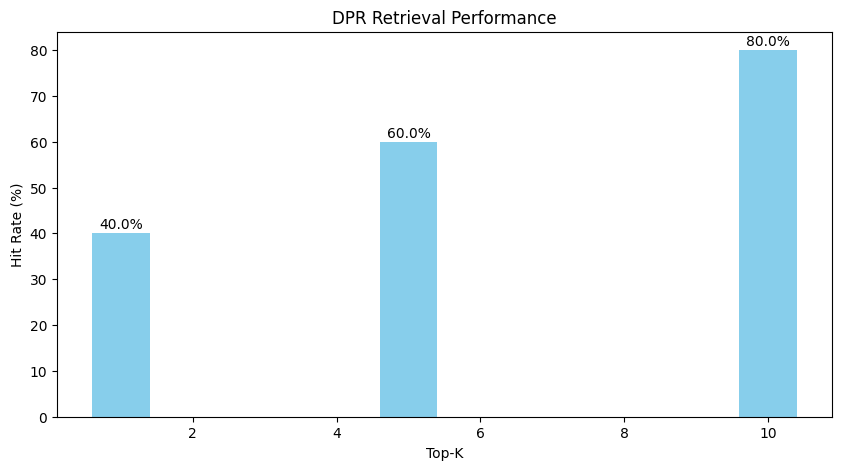


Summary:
Top-1 Accuracy: 40.0%
Top-5 Accuracy: 60.0%
Top-10 Accuracy: 80.0%


<Figure size 640x480 with 0 Axes>

In [ ]:
# Phân tích và visualization kết quả

# Tạo sample test data
test_questions = [
    "Who wrote Romeo and Juliet?",
    "What is the capital of France?",
    "When was the first iPhone released?",
    "Who discovered gravity?",
    "What is DNA?"
]

test_answers = [
    ["William Shakespeare", "Shakespeare"],
    ["Paris"],
    ["2007", "January 2007"],
    ["Isaac Newton", "Newton"],
    ["Deoxyribonucleic acid"]
]

def analyze_retrieval_quality(questions, answers):
    """Đánh giá chất lượng retrieval"""
    top_k_hits = {1:[], 5:[], 10:[]}

    print("Analyzing retrieval quality...")
    for q, ans in zip(questions, answers):
        print(f"\nQuestion: {q}")
        results = retrieve_passages(q, top_k=10)

        # Check if answer exists in each top-k
        for k in top_k_hits.keys():
            retrieved_texts = [r['text'].lower() for r in results[:k]]
            found = any(a.lower() in txt for a in ans for txt in retrieved_texts)
            top_k_hits[k].append(found)

            # Print detailed results for k=1
            if k == 1:
                display(HTML(f"""
                <div style='margin:10px; padding:10px; border:1px solid #ccc'>
                    <b>Top result:</b><br>
                    <i>{results[0]['title']}</i><br>
                    {results[0]['text'][:200]}...<br>
                    <b>Answer found: {'Yes' if found else 'No'}</b>
                </div>
                """))

    # Plot results
    plt.figure(figsize=(10,5))
    x = list(top_k_hits.keys())
    y = [np.mean(v)*100 for v in top_k_hits.values()]

    plt.bar(x, y, color='skyblue')
    plt.xlabel('Top-K')
    plt.ylabel('Hit Rate (%)')
    plt.title('DPR Retrieval Performance')

    # Add value labels on bars
    for i, v in enumerate(y):
        plt.text(x[i], v + 1, f'{v:.1f}%', ha='center')

    plt.show()

    # Print summary
    print("\nSummary:")
    for k, hits in top_k_hits.items():
        print(f"Top-{k} Accuracy: {np.mean(hits)*100:.1f}%")

# Run analysis
analyze_retrieval_quality(test_questions, test_answers)

# Save results
plt.savefig('retrieval_performance.png')

Khi run có thể hỏi câu hỏi bất kì bằng cách nhập vào

In [14]:
# Giao diện tương tác
def create_interactive_demo():
    question_input = widgets.Text(
        value='',
        placeholder='Nhập câu hỏi của bạn...',
        description='Câu hỏi:',
        disabled=False
    )

    k_slider = widgets.IntSlider(
        value=5,
        min=1,
        max=10,
        step=1,
        description='Top-K:',
        disabled=False
    )

    output = widgets.Output()

    def on_button_click(b):
        with output:
            output.clear_output()
            results = retrieve_passages(
                question_input.value,
                top_k=k_slider.value
            )
            print(f"Câu hỏi: {question_input.value}\n")
            for i, res in enumerate(results, 1):
                print(f"Kết quả {i}:")
                print(f"Score: {res['score']:.3f}")
                print(f"Title: {res['title']}")
                print(f"Text: {res['text']}\n")

    button = widgets.Button(description="Tìm kiếm")
    button.on_click(on_button_click)

    display(question_input, k_slider, button, output)

create_interactive_demo()

Text(value='', description='Câu hỏi:', placeholder='Nhập câu hỏi của bạn...')

IntSlider(value=5, description='Top-K:', max=10, min=1)

Button(description='Tìm kiếm', style=ButtonStyle())

Output()

# Kiểm thử và đánh giá (trên số lượng data rất nhỏ)

In [15]:
# Test: Kiểm tra toàn bộ pipeline
def test_dpr_pipeline():
    print("1. Kiểm tra GPU:")
    print(f"Device being used: {device}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"Memory: {torch.cuda.get_device_properties(0).total_memory/1e9:.2f} GB")
    print("\n" + "="*50 + "\n")

    print("2. Kiểm tra Model loading:")
    print(f"Question encoder initialized: {question_encoder is not None}")
    print(f"Context encoder initialized: {context_encoder is not None}")
    print("\n" + "="*50 + "\n")

    print("3. Kiểm tra Passages:")
    print(f"Total passages loaded: {len(passages)}")
    print("\nSample passage:")
    sample_passage = passages[0]
    print(f"ID: {sample_passage['id']}")
    print(f"Title: {sample_passage['title']}")
    print(f"Text: {sample_passage['text'][:200]}...")
    print("\n" + "="*50 + "\n")

    print("4. Kiểm tra Embeddings:")
    print(f"Passage embeddings shape: {passage_embeddings.shape}")
    print(f"FAISS index size: {index.ntotal}")
    print("\n" + "="*50 + "\n")

    print("5. Test Retrieval với các câu hỏi đa dạng:")
    test_questions = [
        "Who wrote Romeo and Juliet?",  # Văn học
        "What is the capital of France?",  # Địa lý
        "When did World War 2 end?",  # Lịch sử
        "What is DNA?",  # Khoa học
        "Who invented the telephone?"  # Công nghệ
    ]

    for q in test_questions:
        print(f"\nQuestion: {q}")
        results = retrieve_passages(q, top_k=2)
        for i, res in enumerate(results, 1):
            print(f"\nResult {i}:")
            print(f"Score: {res['score']:.3f}")
            print(f"Title: {res['title']}")
            print(f"Text: {res['text'][:150]}...")
    print("\n" + "="*50 + "\n")

    print("6. Performance Stats:")
    import time
    start_time = time.time()
    _ = retrieve_passages("test question", top_k=5)
    retrieval_time = time.time() - start_time
    print(f"Average retrieval time: {retrieval_time:.3f} seconds")

    print("\nMemory Usage:")
    import psutil
    process = psutil.Process()
    print(f"Memory used: {process.memory_info().rss / 1024 / 1024:.2f} MB")

# Run tests
test_dpr_pipeline()

1. Kiểm tra GPU:
Device being used: cuda
CUDA available: True
GPU: Tesla T4
Memory: 15.84 GB


2. Kiểm tra Model loading:
Question encoder initialized: True
Context encoder initialized: True


3. Kiểm tra Passages:
Total passages loaded: 100000

Sample passage:
ID: 1
Title: Aaron
Text: "Aaron Aaron ( or ; ""Ahärôn"") is a prophet, high priest, and the brother of Moses in the Abrahamic religions. Knowledge of Aaron, along with his brother Moses, comes exclusively from religious texts...


4. Kiểm tra Embeddings:
Passage embeddings shape: torch.Size([100000, 768])
FAISS index size: 200000


5. Test Retrieval với các câu hỏi đa dạng:

Question: Who wrote Romeo and Juliet?

Result 1:
Score: 71.495
Title: "Christopher Marlowe"
Text: "were probably written especially for him. Marlowe's plays were the foundation of the repertoire of Alleyn's company, the Admiral's Men, throughout th...

Result 2:
Score: 71.495
Title: "Dale Earnhardt"
Text: "No. 3. Rudd went to Bud Moore's No. 15, replacing Ea

Tạo file đánh giá và checkpoint

Starting evaluation...


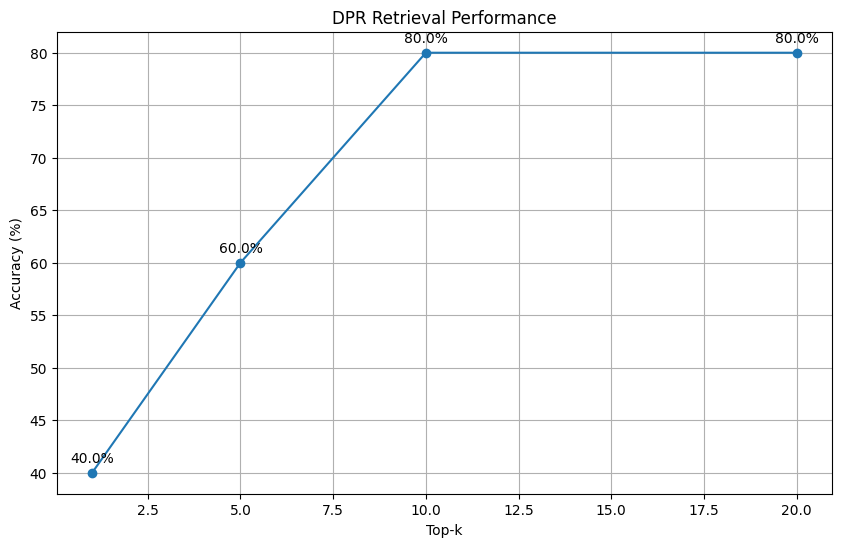


Evaluation Summary:
Total questions evaluated: 5
Average retrieval time: 0.016s

Accuracy:
top_1: 40.0%
top_5: 60.0%
top_10: 80.0%
top_20: 80.0%

Checkpoint saved to: checkpoints/dpr_checkpoint_20241217_1809.pt
Results saved to: checkpoints/evaluation_results.json


In [ ]:
# Model Evaluation và Checkpoint Generation

def evaluate_dpr_model(
    question_encoder,
    context_encoder,
    test_questions,
    test_answers,
    passages,
    device,
    save_dir='checkpoints'
):
    """Đánh giá model DPR và lưu checkpoint"""

    # Tạo thư mục lưu kết quả
    save_dir = Path(save_dir)
    save_dir.mkdir(exist_ok=True)

    metrics = {
        'top_k_accuracy': {k: [] for k in [1, 5, 10, 20]},
        'retrieval_time': [],
        'total_questions': len(test_questions)
    }

    results = []

    print("Starting evaluation...")
    start_time = time.time()

    # Đánh giá mỗi question
    for q, ans in zip(test_questions, test_answers):
        q_start = time.time()
        retrieved = retrieve_passages(q, top_k=20)
        retrieval_time = time.time() - q_start

        for k in metrics['top_k_accuracy'].keys():
            top_k_texts = [r['text'].lower() for r in retrieved[:k]]
            found = any(a.lower() in txt for a in ans for txt in top_k_texts)
            metrics['top_k_accuracy'][k].append(found)

        metrics['retrieval_time'].append(retrieval_time)

        results.append({
            'question': q,
            'answers': ans,
            'retrieved': retrieved,
            'retrieval_time': retrieval_time
        })

    final_metrics = {
        'average_retrieval_time': np.mean(metrics['retrieval_time']),
        'total_evaluation_time': time.time() - start_time,
        'accuracy': {
            f'top_{k}': np.mean(v) * 100
            for k, v in metrics['top_k_accuracy'].items()
        }
    }

    checkpoint_path = save_dir / f'dpr_checkpoint_{datetime.now():%Y%m%d_%H%M}.pt'
    torch.save({
        'question_encoder_state': question_encoder.state_dict(),
        'context_encoder_state': context_encoder.state_dict(),
        'metrics': final_metrics,
        'config': {
            'num_passages': len(passages),
            'device': str(device)
        }
    }, checkpoint_path)

    results_path = save_dir / 'evaluation_results.json'
    with open(results_path, 'w') as f:
        json.dump({
            'metrics': final_metrics,
            'detailed_results': results
        }, f, indent=2)

    plt.figure(figsize=(10, 6))
    acc_values = list(final_metrics['accuracy'].values())
    k_values = [1, 5, 10, 20]

    plt.plot(k_values, acc_values, marker='o')
    plt.xlabel('Top-k')
    plt.ylabel('Accuracy (%)')
    plt.title('DPR Retrieval Performance')
    plt.grid(True)

    for x, y in zip(k_values, acc_values):
        plt.text(x, y+1, f'{y:.1f}%', ha='center')

    plt.savefig(save_dir / 'performance_plot.png')
    plt.show()

    print("\nEvaluation Summary:")
    print(f"Total questions evaluated: {metrics['total_questions']}")
    print(f"Average retrieval time: {final_metrics['average_retrieval_time']:.3f}s")
    print("\nAccuracy:")
    for k, acc in final_metrics['accuracy'].items():
        print(f"{k}: {acc:.1f}%")
    print(f"\nCheckpoint saved to: {checkpoint_path}")
    print(f"Results saved to: {results_path}")

    return final_metrics, results

# Kiểm thử
test_questions = [
    "Who wrote Romeo and Juliet?",
    "What is the capital of France?",
    "When did World War 2 end?",
    "What is DNA?",
    "Who invented the telephone?"
]

test_answers = [
    ["William Shakespeare"],
    ["Paris"],
    ["1945", "September 1945"],
    ["Deoxyribonucleic acid"],
    ["Alexander Graham Bell", "Bell"]
]

# Đánh giá sau cùng
metrics, results = evaluate_dpr_model(
    question_encoder,
    context_encoder,
    test_questions,
    test_answers,
    passages,
    device
)

# So sánh kết quả và thời gian khi thử tiền xử lý dữ liệu

In [17]:
import re
def preprocess_passages(passages, max_length=256):
    """
    Tiền xử lý passages:
    1. Clean text
    2. Truncate to max_length
    3. Remove duplicates
    4. Create FAISS-friendly format
    """
    processed = []
    seen = set()

    for p in tqdm(passages):
        text = p['text'].strip().lower()
        text = re.sub(r'\s+', ' ', text)

        key = f"{p['title']}_{text[:100]}"

        if key not in seen and len(text.split()) >= 10:
            seen.add(key)
            processed.append({
                'id': p['id'],
                'title': p['title'],
                'text': text[:max_length]
            })

    return processed

def preprocess_questions(questions):
    """Chuẩn hóa câu hỏi"""
    processed = []
    for q in questions:

        q = q.strip().lower()
        q = re.sub(r'\s+', ' ', q)

        if not q.endswith('?'):
            q += '?'

        processed.append(q)

    return processed

  0%|          | 0/100000 [00:00<?, ?it/s]

Starting evaluation...


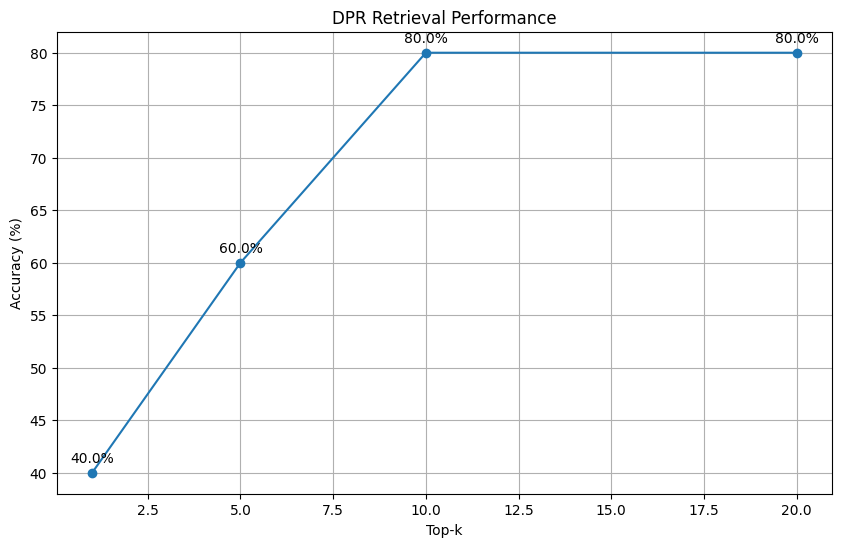


Evaluation Summary:
Total questions evaluated: 5
Average retrieval time: 0.016s

Accuracy:
top_1: 40.0%
top_5: 60.0%
top_10: 80.0%
top_20: 80.0%

Checkpoint saved to: checkpoints/preprocessed/dpr_checkpoint_20241217_1809.pt
Results saved to: checkpoints/preprocessed/evaluation_results.json


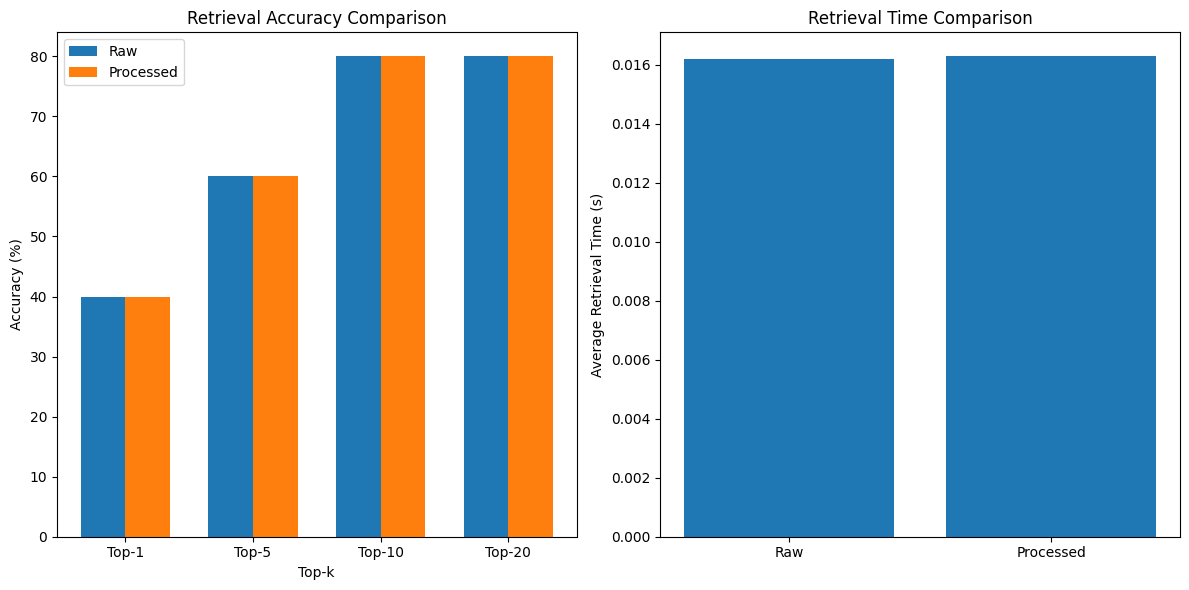


Detailed Comparison:
            Metric  Without Preprocessing  With Preprocessing
             Top-1              40.000000           40.000000
             Top-5              60.000000           60.000000
            Top-10              80.000000           80.000000
            Top-20              80.000000           80.000000
Avg Retrieval Time               0.016201            0.016288


In [ ]:
# So sánh kết quả khi Có/Không tiền xử lí

def compare_preprocessing_results():
    """So sánh kết quả retrieval có và không có tiền xử lý"""

    # Load kết quả hiện tại (chưa tiền xử lí)
    with open('/content/DPR/checkpoints/evaluation_results.json', 'r') as f:
        raw_results = json.load(f)

    # Đánh giá sau khi tiền xử lí
    processed_metrics, processed_detailed = evaluate_dpr_model(
        question_encoder,
        context_encoder,
        preprocess_questions(test_questions),
        test_answers,
        preprocess_passages(passages),
        device,
        save_dir='checkpoints/preprocessed'
    )

    # Tạo dataframe so sánh
    comparison = pd.DataFrame({
        'Metric': ['Top-1', 'Top-5', 'Top-10', 'Top-20', 'Avg Retrieval Time'],
        'Without Preprocessing': [
            raw_results['metrics']['accuracy']['top_1'],
            raw_results['metrics']['accuracy']['top_5'],
            raw_results['metrics']['accuracy']['top_10'],
            raw_results['metrics']['accuracy']['top_20'],
            raw_results['metrics']['average_retrieval_time']
        ],
        'With Preprocessing': [
            processed_metrics['accuracy']['top_1'],
            processed_metrics['accuracy']['top_5'],
            processed_metrics['accuracy']['top_10'],
            processed_metrics['accuracy']['top_20'],
            processed_metrics['average_retrieval_time']
        ]
    })

    # Biểu đồ so sánh
    plt.figure(figsize=(12, 6))

    # So sánh về độ chính xác
    plt.subplot(1, 2, 1)
    acc_data = comparison.iloc[:4]
    x = np.arange(len(acc_data['Metric']))
    width = 0.35

    plt.bar(x - width/2, acc_data['Without Preprocessing'], width, label='Raw')
    plt.bar(x + width/2, acc_data['With Preprocessing'], width, label='Processed')

    plt.xlabel('Top-k')
    plt.ylabel('Accuracy (%)')
    plt.title('Retrieval Accuracy Comparison')
    plt.xticks(x, acc_data['Metric'])
    plt.legend()

    # So sánh thời gian
    plt.subplot(1, 2, 2)
    time_data = comparison.iloc[4:]
    plt.bar(['Raw', 'Processed'],
            [time_data['Without Preprocessing'].iloc[0],
             time_data['With Preprocessing'].iloc[0]])
    plt.ylabel('Average Retrieval Time (s)')
    plt.title('Retrieval Time Comparison')

    plt.tight_layout()
    plt.savefig('preprocessing_comparison.png')
    plt.show()

    print("\nDetailed Comparison:")
    print(comparison.to_string(index=False))

    return comparison

# So sánh kết quả tổng kết
comparison_results = compare_preprocessing_results()

# Đánh giá với 3000 question

Loading test data...

Evaluating on 3610 questions...


100%|██████████| 113/113 [00:55<00:00,  2.04it/s]


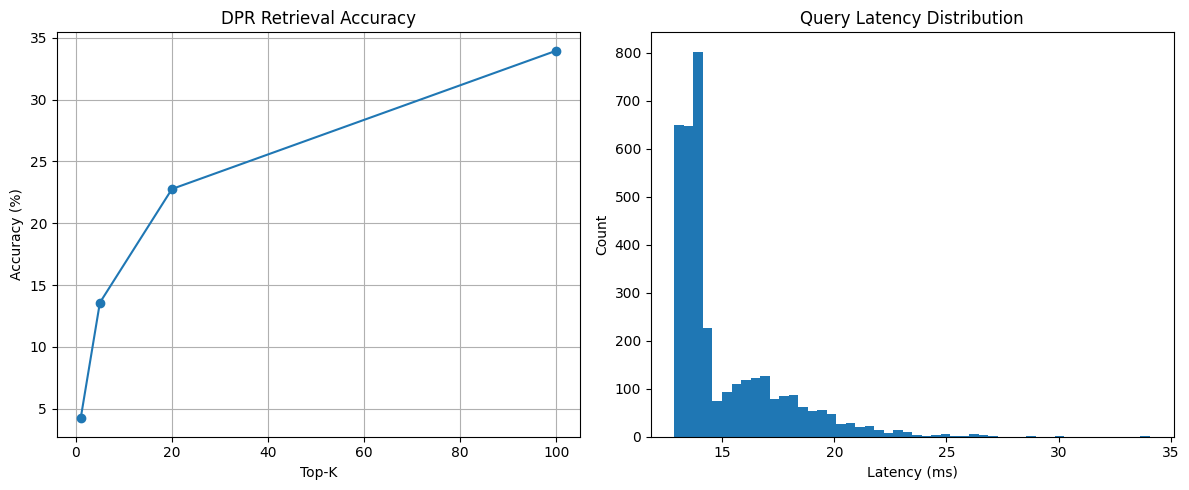


RESULTS ON NQ TEST:
--------------------------------------------------
Accuracy:
top_1     : 4.21%
top_5     : 13.57%
top_20    : 22.77%
top_100   : 33.96%

Latency (ms):
mean      : 15.06
median    : 13.95
p90       : 18.61
p95       : 20.06

Throughput: 66.38 queries/second

Comparison with paper results:
--------------------------------------------------
Top-  1: 4.21% vs 52.47% (Diff: -48.26%)
Top-  5: 13.57% vs 72.24% (Diff: -58.67%)
Top- 20: 22.77% vs 81.33% (Diff: -58.56%)
Top-100: 33.96% vs 87.29% (Diff: -53.33%)


In [ ]:
# Đánh giá DPR trên NQ test dataset theo metric của paper
def evaluate_dpr_nq(question_encoder, context_encoder, csv_path, passages, device):
    """
    Đánh giá mô hình DPR theo metric của paper gốc:
    - Top-k accuracy (k=1,5,20,100)
    - Latency (ms/query)
    - Throughput (queries/second)

    Args:
        csv_path: Đường dẫn file NQ test csv
        question_encoder: Model encode câu hỏi
        context_encoder: Model encode đoạn văn
    """

    # Load test data
    print("Loading test data...")
    df = pd.read_csv(csv_path, sep='\t', names=['question', 'answers'])
    questions = df['question'].tolist()
    answers = [eval(ans) for ans in df['answers']]

    # Metric tracking
    top_k_hits = {1: [], 5: [], 20: [], 100: []}  # Theo paper
    latencies = []
    batch_size = 32

    print(f"\nEvaluating on {len(questions)} questions...")

    # Đánh giá từng batch
    for i in tqdm(range(0, len(questions), batch_size)):
        batch_questions = questions[i:i+batch_size]
        batch_answers = answers[i:i+batch_size]

        # Đo thời gian cho mỗi batch
        batch_start = time.time()

        # Lấy kết quả cho mỗi câu hỏi trong batch
        for q, ans in zip(batch_questions, batch_answers):
            query_start = time.time()

            # Lấy top 100 passages theo paper
            results = retrieve_passages(q, top_k=100)
            latencies.append((time.time() - query_start) * 1000)  # Convert to ms

            # Kiểm tra độ chính xác ở các ngưỡng k
            for k in top_k_hits.keys():
                retrieved_texts = [r['text'].lower() for r in results[:k]]
                found = any(a.lower() in txt for a in ans for txt in retrieved_texts)
                top_k_hits[k].append(found)

    # Tính toán các metric
    metrics = {
        'accuracy': {f'top_{k}': np.mean(hits) * 100 for k, hits in top_k_hits.items()},
        'latency': {
            'mean': np.mean(latencies),
            'median': np.median(latencies),
            'p90': np.percentile(latencies, 90),
            'p95': np.percentile(latencies, 95)
        },
        'throughput': len(questions) / sum(latencies) * 1000  # queries/second
    }

    # Vẽ biểu đồ kết quả
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    x = list(top_k_hits.keys())
    y = [metrics['accuracy'][f'top_{k}'] for k in x]
    plt.plot(x, y, marker='o')
    plt.xlabel('Top-K')
    plt.ylabel('Accuracy (%)')
    plt.title('DPR Retrieval Accuracy')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.hist(latencies, bins=50)
    plt.xlabel('Latency (ms)')
    plt.ylabel('Count')
    plt.title('Query Latency Distribution')

    plt.tight_layout()
    plt.savefig('nq_evaluation.png')
    plt.show()

    # In kết quả chi tiết
    print("\nRESULTS ON NQ TEST:")
    print("-" * 50)
    print("Accuracy:")
    for k, acc in metrics['accuracy'].items():
        print(f"{k:10}: {acc:.2f}%")

    print("\nLatency (ms):")
    for metric, value in metrics['latency'].items():
        print(f"{metric:10}: {value:.2f}")

    print(f"\nThroughput: {metrics['throughput']:.2f} queries/second")

    # So sánh với kết quả paper
    paper_results = {
        'top_1': 52.47,
        'top_5': 72.24,
        'top_20': 81.33,
        'top_100': 87.29
    }

    print("\nComparison with paper results:")
    print("-" * 50)
    for k in [1, 5, 20, 100]:
        diff = metrics['accuracy'][f'top_{k}'] - paper_results[f'top_{k}']
        print(f"Top-{k:3}: {metrics['accuracy'][f'top_{k}']:.2f}% vs {paper_results[f'top_{k}']:.2f}% (Diff: {diff:+.2f}%)")

    return metrics

# Chạy đánh giá
metrics = evaluate_dpr_nq(
    question_encoder=question_encoder,
    context_encoder=context_encoder,
    csv_path='/content/DPR/downloads/data/retriever/qas/nq-test.csv',
    passages=passages,
    device=device
)

In [20]:
# Save evaluation results to files
def save_evaluation_results(metrics, output_dir='evaluation_results'):
    """
    Lưu kết quả đánh giá thành các file:
    - metrics.json: Các metric số liệu
    - accuracy_plot.png: Biểu đồ accuracy
    - latency_plot.png: Biểu đồ latency
    - full_report.txt: Báo cáo chi tiết
    """
    import os
    import json
    from datetime import datetime

    # Tạo thư mục kết quả
    os.makedirs(output_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Lưu metrics dạng JSON
    metrics_file = os.path.join(output_dir, f'metrics_{timestamp}.json')
    with open(metrics_file, 'w') as f:
        json.dump(metrics, f, indent=2)

    # Lưu báo cáo chi tiết dạng text
    report_file = os.path.join(output_dir, f'report_{timestamp}.txt')
    with open(report_file, 'w') as f:
        f.write("DPR EVALUATION REPORT\n")
        f.write("===================\n\n")
        f.write(f"Evaluation time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")

        f.write("ACCURACY\n")
        f.write("---------\n")
        for k, acc in metrics['accuracy'].items():
            f.write(f"{k:10}: {acc:.2f}%\n")

        f.write("\nLATENCY (ms)\n")
        f.write("------------\n")
        for metric, value in metrics['latency'].items():
            f.write(f"{metric:10}: {value:.2f}\n")

        f.write(f"\nTHROUGHPUT: {metrics['throughput']:.2f} queries/second\n")

    # Lưu biểu đồ accuracy
    plt.figure(figsize=(8, 6))
    x = list(metrics['accuracy'].keys())
    y = [metrics['accuracy'][k] for k in x]
    plt.plot(x, y, marker='o')
    plt.xlabel('Top-K')
    plt.ylabel('Accuracy (%)')
    plt.title('DPR Retrieval Accuracy')
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, f'accuracy_{timestamp}.png'))
    plt.close()

    # Lưu biểu đồ phân phối latency
    plt.figure(figsize=(8, 6))
    plt.hist(metrics['latency'].values(), bins=50)
    plt.xlabel('Latency (ms)')
    plt.ylabel('Count')
    plt.title('Query Latency Distribution')
    plt.savefig(os.path.join(output_dir, f'latency_{timestamp}.png'))
    plt.close()

    print(f"\nSaved evaluation results to {output_dir}:")
    print(f"- Metrics: {metrics_file}")
    print(f"- Report: {report_file}")
    print(f"- Plots: accuracy_{timestamp}.png, latency_{timestamp}.png")

# Lưu kết quả sau khi đánh giá
save_evaluation_results(metrics)


Saved evaluation results to evaluation_results:
- Metrics: evaluation_results/metrics_20241217_181216.json
- Report: evaluation_results/report_20241217_181216.txt
- Plots: accuracy_20241217_181216.png, latency_20241217_181216.png


In [ ]:
def save_dpr_evaluation_results(questions, answers, retrieved_results, output_dir='paper_format_results'):
    """
    Save evaluation results in DPR paper format
    """
    import os
    import json
    from datetime import datetime

    os.makedirs(output_dir, exist_ok=True)

    # Format như trong README của DPR paper
    results = {
        "dataset": "nq-test",
        "model": "checkpoint.retriever.single-adv-hn.nq.bert-base-encoder",
        "results": []
    }

    # Process mỗi câu hỏi
    for q_idx, (question, answer, retrieval) in enumerate(zip(questions, answers, retrieved_results)):
        result = {
            "question": question,
            "answers": answer,
            "ctxs": [
                {
                    "id": p["id"],
                    "title": p["title"],
                    "text": p["text"],
                    "score": float(p["score"]),
                    "has_answer": any(ans.lower() in p["text"].lower() for ans in answer)
                }
                for p in retrieval[:100]  # Top 100 theo paper
            ]
        }
        results["results"].append(result)

    # Lưu file chính
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    main_output = os.path.join(output_dir, f'retriever_results.nq.single-adv-hn.test_{timestamp}.json')
    with open(main_output, 'w') as f:
        json.dump(results, f, indent=2)

    # Lưu metrics summary
    metrics = {
        "top_k_accuracy": {
            "top_1": calculate_topk_accuracy(results, k=1),
            "top_5": calculate_topk_accuracy(results, k=5),
            "top_20": calculate_topk_accuracy(results, k=20),
            "top_100": calculate_topk_accuracy(results, k=100)
        },
        "timestamp": timestamp,
        "num_questions": len(questions)
    }

    metrics_file = os.path.join(output_dir, f'metrics_summary_{timestamp}.json')
    with open(metrics_file, 'w') as f:
        json.dump(metrics, f, indent=2)

    print(f"\nSaved results in DPR paper format:")
    print(f"- Main results: {main_output}")
    print(f"- Metrics summary: {metrics_file}")

    return results, metrics

def calculate_topk_accuracy(results, k):
    """Calculate top-k accuracy from results"""
    correct = sum(
        1 for r in results["results"]
        if any(ctx["has_answer"] for ctx in r["ctxs"][:k])
    )
    return correct / len(results["results"]) * 100

df = pd.read_csv('/content/DPR/downloads/data/retriever/qas/nq-test.csv', sep='\t', names=['question', 'answers'])


def format_retrieved_passage(passage, score):
    """Format passage with required fields"""
    return {
        "id": str(passage.get("passage_id", "unknown")),  # Add default ID
        "title": passage.get("title", ""),
        "text": passage["text"],
        "score": float(score),
        "passage_id": passage.get("passage_id", "unknown"),
        "metadata": {}  
    }

retrieved_passages_list = []

for question in tqdm(df['question'].tolist(), desc="Retrieving passages"):
    raw_passages = retrieve_passages(question, top_k=100)

    formatted_passages = [
        format_retrieved_passage(p, p.get("score", 0.0))
        for p in raw_passages
    ]

    retrieved_passages_list.append(formatted_passages)


results, metrics = save_dpr_evaluation_results(
    questions=df['question'].tolist(),
    answers=[eval(ans) for ans in df['answers']],
    retrieved_results=retrieved_passages_list
)


Retrieving passages: 100%|██████████| 3610/3610 [01:00<00:00, 59.88it/s]



Saved results in DPR paper format:
- Main results: paper_format_results/retriever_results.nq.single-adv-hn.test_20241217_183115.json
- Metrics summary: paper_format_results/metrics_summary_20241217_183115.json


In [ ]:
def save_question_checkpoints(questions, answers, output_dir='question_checkpoints'):
    """Save individual question results in DPR format"""

    os.makedirs(output_dir, exist_ok=True)

    for idx, (question, answer) in enumerate(tqdm(zip(questions, answers), total=len(questions))):
        retrieved = retrieve_passages(question, top_k=100)

        question_result = {
            "question": question,
            "answers": eval(answer) if isinstance(answer, str) else answer,
            "positive_ctxs": [
                {
                    "title": p.get("title", ""),
                    "text": p["text"],
                    "score": float(p.get("score", 0.0)),
                    "passage_id": str(p.get("passage_id", f"passage_{idx}"))
                }
                for p in retrieved if any(ans.lower() in p["text"].lower()
                                        for ans in (eval(answer) if isinstance(answer, str) else answer))
            ],
            "negative_ctxs": [
                {
                    "title": p.get("title", ""),
                    "text": p["text"],
                    "score": float(p.get("score", 0.0)),
                    "passage_id": str(p.get("passage_id", f"passage_{idx}"))
                }
                for p in retrieved[:5] if not any(ans.lower() in p["text"].lower()
                                                for ans in (eval(answer) if isinstance(answer, str) else answer))
            ],
            "hard_negative_ctxs": [
                {
                    "title": p.get("title", ""),
                    "text": p["text"],
                    "score": float(p.get("score", 0.0)),
                    "passage_id": str(p.get("passage_id", f"passage_{idx}"))
                }
                for p in retrieved[5:10] if not any(ans.lower() in p["text"].lower()
                                                  for ans in (eval(answer) if isinstance(answer, str) else answer))
            ]
        }

        checkpoint_file = os.path.join(output_dir, f'question_{idx:04d}.json')
        with open(checkpoint_file, 'w') as f:
            json.dump(question_result, f, indent=2)

        if idx % 100 == 0:
            summary = {
                "processed_questions": idx + 1,
                "total_questions": len(questions),
                "timestamp": datetime.now().isoformat(),
                "last_checkpoint": checkpoint_file
            }
            with open(os.path.join(output_dir, 'progress.json'), 'w') as f:
                json.dump(summary, f, indent=2)

df = pd.read_csv('/content/DPR/downloads/data/retriever/qas/nq-test.csv', sep='\t', names=['question', 'answers'])
save_question_checkpoints(
    questions=df['question'].tolist(),
    answers=df['answers'].tolist()
)

100%|██████████| 3610/3610 [01:04<00:00, 56.00it/s]


In [ ]:
def save_dpr_questions_file(questions, answers, output_file='dpr_questions.json'):
    """Save all questions in single DPR format file"""


    results = []

    for idx, (question, answer) in enumerate(tqdm(zip(questions, answers), total=len(questions))):
        retrieved = retrieve_passages(question, top_k=100)

        question_result = {
            "question": question,
            "answers": eval(answer) if isinstance(answer, str) else answer,
            "positive_ctxs": [
                {
                    "title": p.get("title", ""),
                    "text": p["text"]
                }
                for p in retrieved if any(ans.lower() in p["text"].lower()
                                        for ans in (eval(answer) if isinstance(answer, str) else answer))
            ],
            "negative_ctxs": [
                {
                    "title": p.get("title", ""),
                    "text": p["text"]
                }
                for p in retrieved[:5] if not any(ans.lower() in p["text"].lower()
                                                for ans in (eval(answer) if isinstance(answer, str) else answer))
            ],
            "hard_negative_ctxs": [
                {
                    "title": p.get("title", ""),
                    "text": p["text"]
                }
                for p in retrieved[5:10] if not any(ans.lower() in p["text"].lower()
                                                  for ans in (eval(answer) if isinstance(answer, str) else answer))
            ]
        }
        results.append(question_result)

        if idx % 100 == 0:
            with open(f'{output_file}.backup', 'w') as f:
                json.dump({
                    "timestamp": datetime.now().isoformat(),
                    "processed": idx + 1,
                    "total": len(questions),
                    "results": results
                }, f, indent=2)

    with open(output_file, 'w') as f:
        json.dump(results, f, indent=2)

    print(f"Saved {len(results)} questions to {output_file}")

df = pd.read_csv('/content/DPR/downloads/data/retriever/qas/nq-test.csv', sep='\t', names=['question', 'answers'])
save_dpr_questions_file(
    questions=df['question'].tolist(),
    answers=df['answers'].tolist(),
    output_file='nq_test_questions.json'
)

100%|██████████| 3610/3610 [01:12<00:00, 49.97it/s]


Saved 3610 questions to nq_test_questions.json
